In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

%matplotlib inline

import logging

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

In [12]:
from scipy.spatial.distance import squareform
import seaborn as sns

In [49]:
num_nodes = 64
embed_dims = [2, 5, 10, 20, 30, 40]
num_embed_dims = len(embed_dims)

embed_types = ['Euclidean', 'Hyperbolic', 'WassR2', 'WassR3', 'KL']
num_embed_types = len(embed_types)

loss_reg = np.zeros((num_embed_types, num_embed_dims, 10))
time_reg = np.zeros((num_embed_types, num_embed_dims, 8))

time_graphs = [1, 3, 5, 6, 7, 8, 9, 10]

embeddings = []
embed_distances = []

for graph_id in range(10):
    for i, embed_type in enumerate(embed_types):
        for j, embed_dim in enumerate(embed_dims):
            res = np.load('./results/scale_free_{}_{}_{}_{}.npz'.format(num_nodes, graph_id+1, embed_type, embed_dim))
            loss_history = res['loss']
            loss = loss_history[-1]
            loss_reg[i, j, graph_id] = loss
            
            if graph_id == 0 and embed_dim == 40:
                embeddings.append(res['embeddings'])
                embed_distances.append(res['embed_distances'])
            
for g, graph_id in enumerate(time_graphs):
    for i, embed_type in enumerate(embed_types):
        for j, embed_dim in enumerate(embed_dims):
            res = np.load('./results/scale_free_{}_{}_{}_{}.npz'.format(num_nodes, graph_id, embed_type, embed_dim))
            time_history = res['time']
            t = time_history[-1]
            time_reg[i, j, g] = t

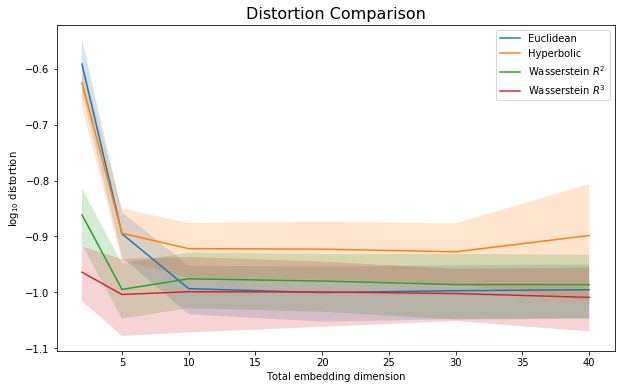

In [50]:
Euc_loss, Hyper_loss, WassR2_loss, WassR3_loss, KL_loss = loss_reg

mean_Euc_loss = np.mean(Euc_loss, axis=-1)
std_Euc_loss = np.std(Euc_loss, axis=-1)
upper_confidence_Euc = mean_Euc_loss + 1.96 * std_Euc_loss
lower_confidence_Euc = mean_Euc_loss - 1.96 * std_Euc_loss

mean_Hyper_loss = np.mean(Hyper_loss, axis=-1)
std_Hyper_loss = np.std(Hyper_loss, axis=-1)
upper_confidence_Hyper = mean_Hyper_loss + 1.96 * std_Hyper_loss
lower_confidence_Hyper = mean_Hyper_loss - 1.96 * std_Hyper_loss

mean_WassR2_loss = np.mean(WassR2_loss, axis=-1)
std_WassR2_loss = np.std(WassR2_loss, axis=-1)
upper_confidence_WassR2 = mean_WassR2_loss + 1.96 * std_WassR2_loss
lower_confidence_WassR2 = mean_WassR2_loss - 1.96 * std_WassR2_loss

mean_WassR3_loss = np.mean(WassR3_loss, axis=-1)
std_WassR3_loss = np.std(WassR3_loss, axis=-1)
upper_confidence_WassR3 = mean_WassR3_loss + 1.96 * std_WassR3_loss
lower_confidence_WassR3 = mean_WassR3_loss - 1.96 * std_WassR3_loss

mean_KL_loss = np.mean(KL_loss, axis=-1)
std_KL_loss = np.std(KL_loss, axis=-1)
upper_confidence_KL = mean_KL_loss + 1.96 * std_KL_loss
lower_confidence_KL = mean_KL_loss - 1.96 * std_KL_loss

# plt.figure(figsize=(10, 6))
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(embed_dims, np.log10(mean_Euc_loss), label='Euclidean')
ax.fill_between(embed_dims, np.log10(upper_confidence_Euc), np.log10(lower_confidence_Euc), alpha=0.2)
ax.plot(embed_dims, np.log10(mean_Hyper_loss), label='Hyperbolic')
ax.fill_between(embed_dims, np.log10(upper_confidence_Hyper), np.log10(lower_confidence_Hyper), alpha=0.2)
ax.plot(embed_dims, np.log10(mean_WassR2_loss), label='Wasserstein $R^2$')
ax.fill_between(embed_dims, np.log10(upper_confidence_WassR2), np.log10(lower_confidence_WassR2), alpha=0.2)
ax.plot(embed_dims, np.log10(mean_WassR3_loss), label='Wasserstein $R^3$')
ax.fill_between(embed_dims, np.log10(upper_confidence_WassR3), np.log10(lower_confidence_WassR3), alpha=0.2)
# ax.plot(embed_dims, np.log10(mean_KL_loss), label='KL')
# ax.fill_between(embed_dims, np.log10(upper_confidence_KL), np.log10(lower_confidence_KL), alpha=0.4)
ax.set_xlabel('Total embedding dimension')
ax.set_ylabel('$\log_{10}$ distortion')
ax.set_title('Distortion Comparison', fontsize=16)
ax.legend(loc='best')
# plt.show()

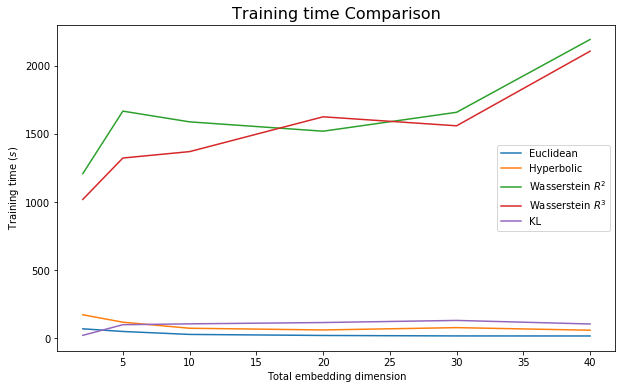

In [51]:
Euc_time, Hyper_time, WassR2_time, WassR3_time, KL_time = time_reg

mean_Euc_time = np.mean(Euc_time, axis=-1)
# std_Euc_time = np.std(Euc_time, axis=-1)
# upper_confidence_Euc_time = mean_Euc_time + 1.96 * std_Euc_time
# lower_confidence_Euc_time = mean_Euc_time - 1.96 * std_Euc_time

mean_Hyper_time = np.mean(Hyper_time, axis=-1)
# std_Hyper_time = np.std(Hyper_time, axis=-1)
# upper_confidence_Hyper_time = mean_Hyper_time + 1.96 * std_Hyper_time
# lower_confidence_Hyper_time = mean_Hyper_time - 1.96 * std_Hyper_time

mean_WassR2_time = np.mean(WassR2_time, axis=-1)
# std_WassR2_time = np.std(WassR2_time, axis=-1)
# upper_confidence_WassR2_time = mean_WassR2_time + 1.96 * std_WassR2_time
# lower_confidence_WassR2_time = mean_WassR2_time - 1.96 * std_WassR2_time

mean_WassR3_time = np.mean(WassR3_time, axis=-1)
# std_WassR3_time = np.std(WassR3_time, axis=-1)
# upper_confidence_WassR3_time = mean_WassR3_time + 1.96 * std_WassR3_time
# lower_confidence_WassR3_time = mean_WassR3_time - 1.96 * std_WassR3_time

mean_KL_time = np.mean(KL_time, axis=-1)
# std_KL_time = np.std(KL_time, axis=-1)
# upper_confidence_KL_time = mean_KL_time + 1.96 * std_KL_time
# lower_confidence_KL_time = mean_KL_time - 1.96 * std_KL_time

# plt.figure(figsize=(10, 6))
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(embed_dims, mean_Euc_time, label='Euclidean')
# ax.fill_between(embed_dims, np.log10(upper_confidence_Euc_time), np.log10(lower_confidence_Euc_time), alpha=0.2)
ax.plot(embed_dims, mean_Hyper_time, label='Hyperbolic')
# ax.fill_between(embed_dims, np.log10(upper_confidence_Hyper_time), np.log10(lower_confidence_Hyper_time), alpha=0.2)
ax.plot(embed_dims, mean_WassR2_time, label='Wasserstein $R^2$')
# ax.fill_between(embed_dims, np.log10(upper_confidence_WassR2_time), np.log10(lower_confidence_WassR2_time), alpha=0.2)
ax.plot(embed_dims, mean_WassR3_time, label='Wasserstein $R^3$')
# ax.fill_between(embed_dims, np.log10(upper_confidence_WassR3_time), np.log10(lower_confidence_WassR3_time), alpha=0.2)
ax.plot(embed_dims, mean_KL_time, label='KL')
# ax.fill_between(embed_dims, np.log10(upper_confidence_KL_time), np.log10(lower_confidence_KL_time), alpha=0.4)
ax.set_xlabel('Total embedding dimension')
ax.set_ylabel('Training time ($s$)')
ax.set_title('Training time Comparison', fontsize=16)
ax.legend(loc='best')
# plt.show()

In [52]:
print(Hyper_loss)
print(mean_Hyper_loss)
print(std_Hyper_loss)

[[0.23016718 0.23170158 0.23449094 0.22040994 0.24457028 0.25729468
  0.25054837 0.24408573 0.22387775 0.23300687]
 [0.12364459 0.12099129 0.13152485 0.11853406 0.12321941 0.14165117
  0.13623855 0.12598816 0.12298851 0.13076763]
 [0.11627717 0.11598575 0.12208297 0.10981759 0.11536472 0.13574923
  0.12553331 0.11687463 0.11691475 0.1228655 ]
 [0.11658864 0.11568751 0.12242705 0.10699567 0.1162902  0.13565285
  0.12543227 0.1162999  0.11663911 0.12304032]
 [0.11537912 0.11393211 0.12121814 0.1051685  0.1150063  0.13476864
  0.12414388 0.11479815 0.11548325 0.12214317]
 [0.11771156 0.116387   0.12282771 0.16854498 0.11666979 0.13578787
  0.12694802 0.11803041 0.11723296 0.12392853]]
[0.23701533 0.12755482 0.11974656 0.11950535 0.11820413 0.12640688]
[0.01116858 0.00694293 0.00681902 0.00724779 0.00748099 0.01519214]


In [53]:
# visualize the embedding distance results by heatmap for graph 1 and embedding dimension 40
from graph_generator import GraphGenerator

g = nx.read_gpickle("./graphs/scale_free_64_1.pickle")
node_pairs = g.get_node_pairs()
obj_distances = g.get_obj_distances()

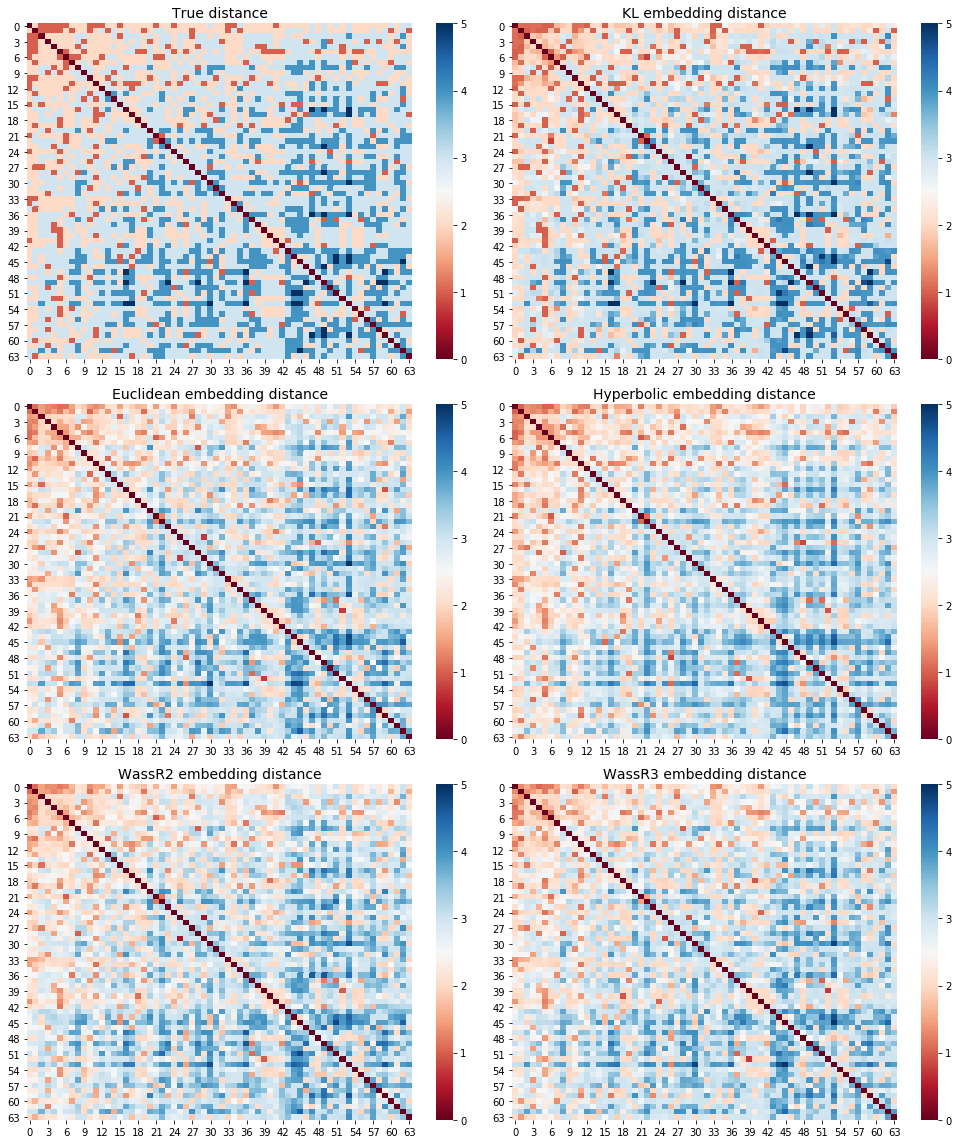

In [54]:
fig = plt.figure(figsize=(14, 16))
# fig.suptitle("Pairwise Distance Heatmap", fontsize=16)

true_distance = squareform(obj_distances)
ax = plt.subplot(321)
ax.set_title('True distance', fontsize=14)
sns.heatmap(true_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

for i, _ in enumerate(embed_types):
    pred_distance = squareform(embed_distances[(i+4)%5])
    ax = plt.subplot(322+i)
    ax.set_title(embed_types[(i+4)%5] + " embedding distance", fontsize=14)
    sns.heatmap(pred_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

plt.tight_layout()

In [65]:
from scipy.spatial.distance import cdist

In [75]:
a = np.random.rand(3)
b = np.random.rand(3)

In [79]:
np.any(np.abs(a - b) > 0.5)

True

In [99]:
def compute_T(K, n_iter, tol):
    u = np.ones((30, 1), dtype=float) / 30
    v = np.ones((30, 1), dtype=float) / 30
    K_tilde = 1. / u * K
    r = np.zeros((30, 1), dtype=float)
    r_new = np.ones((30, 1), dtype=float)
    
    iter_count = 0
    while iter_count < n_iter and np.any(np.abs(r_new - r) > tol):
        r = r_new
        r_new = 1. / K_tilde.dot(v / K.T.dot(r))
    
    c = v / K.T.dot(r)
    T_opt = np.diag(r.flatten()).dot(K.dot(np.diag(c.flatten())))
    return T_opt

def wass_distance(n1, n2, embeddings, lambd, n_iter, tol):
    support_1 = embeddings[n1, :, :]
    support_2 = embeddings[n2, :, :]
    D = cdist(support_1, support_2)
    K = np.exp(-D / lambd)
    T = compute_T(K, n_iter, tol)
    distance = np.trace(D.dot(T.T))
    return distance

def wass_distances(pairs, embeddings, lambd, n_iter, tol):
    results = [wass_distance(n1, n2, embeddings, lambd, n_iter, tol) for n1, n2 in pairs]
    return np.array(results)

def euclidean_distance(n1, n2, embeddings):
    v1 = embeddings[n1, :]
    v2 = embeddings[n2, :]
    distance = np.norm(v1 - v2)
    return distance
    
def euclidean_distances(pairs, embeddings):
    results = [euclidean_distance(n1, n2, embeddings) for n1, n2 in pairs]
    return np.array(results)

def hyperbolic_distance(n1, n2, embeddings, eps=1e-5):
    v1 = embeddings[n1, :]
    v2 = embeddings[n2, :]
    norm1 = np.norm(v1)
    norm2 = np.norm(v2)
    v1 = v1 / norm1 - eps if norm1 >= 1 else v1
    v2 = v2 / norm2 - eps if norm2 >= 1 else v2
    distance = np.arccosh(1 + 2 * np.sum(np.square(v1-v2)) / ((1 - np.sum(np.square(v1))) * (1 - np.sum(np.square(v2)))))
    
    return distance

def hyperbolic_distances(pairs, embeddings, eps=1e-5):
    results = [hyperbolic_distance(n1, n2, embeddings, eps) for n1, n2 in pairs]
    return np.array(results)

def kl_distance(n1, n2, embeddings, eps):
    v1 = embeddings[n1, :]
    v2 = embeddings[n2, :]
    min1 = np.min(v1)
    min2 = np.min(v2)
    v1 = v1 - min1 + eps if min1 <= 0 else v1
    v2 = v2 - min2 + eps if min2 <= 0 else v2
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    distance = 0.5 * (np.sum(v1 * (np.log(v1) - np.log(v2))) + np.sum(v2 * (np.log(v2) - np.log(v1))))
    return distance

def kl_distances(pairs, embeddings, eps=1e-5):
    results = [kl_distance(n1, n2, embeddings, eps) for n1, n2 in pairs]
    return np.array(results)

In [81]:
wass_embeddings = np.load('./results/Sales_WassR2_30.npz')['embeddings']

In [82]:
n_nodes = wass_embeddings.shape[0]
wass_pairs = [[i, j] for i in range(n_nodes) for j in range(i+1, n_nodes)]

In [85]:
wass_embed_distances = wass_distances(wass_pairs, wass_embeddings, 1.0, 20, 1e-5)

In [86]:
wass_embed_distances.shape

(328455,)

In [89]:
obj_min = org_distances.min()
obj_max = org_distances.max()
distance_adjustment = 1e-5
wass_embed_distances = (wass_embed_distances - distance_adjustment) * (obj_max - obj_min) + obj_min

## visualize sales dataset distances heatmap (with normalization)

In [15]:
org_distances = np.loadtxt('./data/Sales_Transaction_Dataset.dist', delimiter=',')

In [63]:
(np.load('./results/Sales_WassR2_30.npz')['embeddings']).shape

(811, 30, 2)

In [95]:
org_distances.min()

0.0

In [94]:
wass_embed_distances.min()

0.01024380854054113

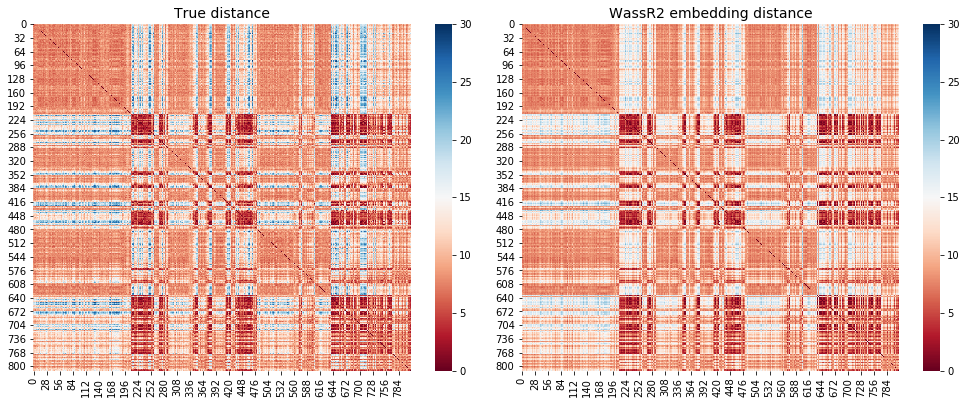

In [91]:
fig = plt.figure(figsize=(14, 16))
# plt.suptitle("Pairwise Distance Heatmap", fontsize=16)

true_distance = org_distances
ax = plt.subplot(321)
ax.set_title('True distance', fontsize=14)
sns.heatmap(true_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

pred_distances = squareform(wass_embed_distances)
ax = plt.subplot(322+i)
ax.set_title(embed_type + " embedding distance", fontsize=14)
sns.heatmap(pred_distances, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

plt.tight_layout()

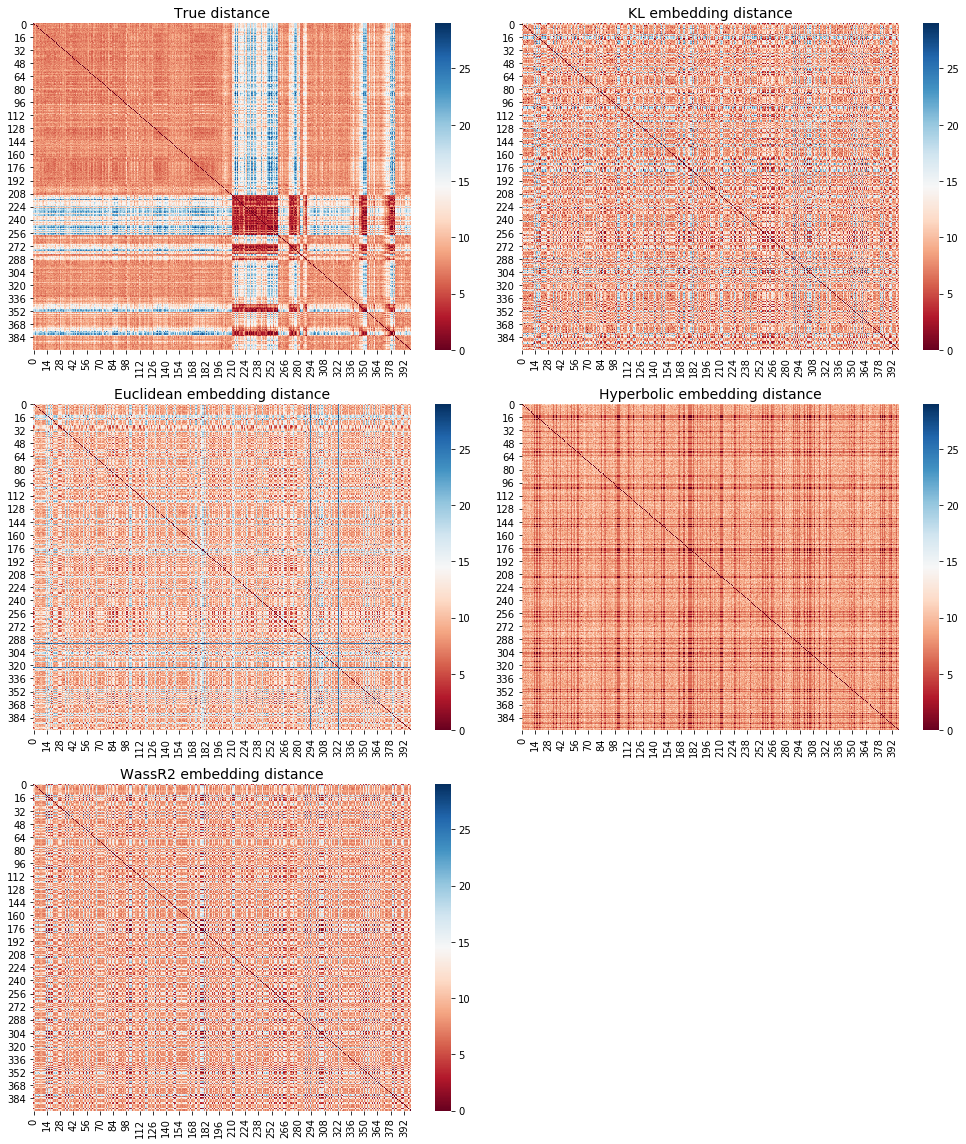

In [58]:
fig = plt.figure(figsize=(14, 16))
# plt.suptitle("Pairwise Distance Heatmap", fontsize=16)

true_distance = org_distances[:400][:, :400]
ax = plt.subplot(321)
ax.set_title('True distance', fontsize=14)
sns.heatmap(true_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

embed_types = ['KL', 'Euclidean', 'Hyperbolic', 'WassR2']
embed_dim = 30
for i, embed_type in enumerate(embed_types):
    pred_distances = np.load('./results/Sales_{}_{}.npz'.format(embed_type, embed_dim))['embed_distances']
    pred_distances = squareform(pred_distances)
    ax = plt.subplot(322+i)
    ax.set_title(embed_type + " embedding distance", fontsize=14)
    sns.heatmap(pred_distances, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

plt.tight_layout()

In [16]:
org_distances = np.loadtxt('./data/Sales_Transaction_Dataset.dist', delimiter=',')

In [17]:
data = np.load('./results/Sales_KL_30_norm.npz')

In [18]:
kl_embed = data['embeddings']
kl_distances = data['embed_distances']
kl_distances = squareform(kl_distances)

In [19]:
x, y = np.where(org_distances == 0)

In [20]:
[(xx, yy) for xx, yy in zip(x,y) if xx!=yy]

[(212, 636),
 (214, 250),
 (214, 253),
 (214, 258),
 (214, 466),
 (214, 675),
 (214, 679),
 (214, 714),
 (216, 231),
 (216, 350),
 (216, 383),
 (216, 463),
 (216, 470),
 (216, 645),
 (216, 705),
 (216, 712),
 (216, 752),
 (227, 229),
 (227, 249),
 (227, 252),
 (227, 278),
 (227, 379),
 (227, 380),
 (227, 381),
 (227, 418),
 (227, 464),
 (227, 465),
 (227, 468),
 (227, 641),
 (227, 642),
 (227, 644),
 (227, 649),
 (227, 651),
 (227, 656),
 (227, 703),
 (227, 715),
 (227, 751),
 (227, 754),
 (227, 766),
 (228, 710),
 (229, 227),
 (229, 249),
 (229, 252),
 (229, 278),
 (229, 379),
 (229, 380),
 (229, 381),
 (229, 418),
 (229, 464),
 (229, 465),
 (229, 468),
 (229, 641),
 (229, 642),
 (229, 644),
 (229, 649),
 (229, 651),
 (229, 656),
 (229, 703),
 (229, 715),
 (229, 751),
 (229, 754),
 (229, 766),
 (231, 216),
 (231, 350),
 (231, 383),
 (231, 463),
 (231, 470),
 (231, 645),
 (231, 705),
 (231, 712),
 (231, 752),
 (232, 235),
 (232, 417),
 (232, 459),
 (232, 664),
 (232, 672),
 (232, 704),

In [102]:
kl_embed.shape, kl_distances.shape

((811, 30), (811, 811))

In [21]:
sorted(enumerate(org_distances[212]), key=lambda x: x[1])

[(212, 0.0),
 (636, 0.0),
 (247, 0.5),
 (276, 0.5),
 (215, 1.0),
 (230, 1.0),
 (237, 1.5),
 (241, 1.5),
 (289, 1.5),
 (421, 1.5),
 (450, 1.5),
 (455, 1.5),
 (456, 1.5),
 (689, 1.5),
 (691, 1.5),
 (749, 1.5),
 (763, 1.5),
 (769, 1.5),
 (240, 2.0),
 (349, 2.0),
 (416, 2.0),
 (451, 2.0),
 (458, 2.0),
 (461, 2.0),
 (573, 2.0),
 (643, 2.0),
 (650, 2.0),
 (661, 2.0),
 (686, 2.0),
 (732, 2.0),
 (747, 2.0),
 (750, 2.0),
 (218, 2.5),
 (220, 2.5),
 (221, 2.5),
 (236, 2.5),
 (238, 2.5),
 (243, 2.5),
 (245, 2.5),
 (251, 2.5),
 (257, 2.5),
 (273, 2.5),
 (345, 2.5),
 (348, 2.5),
 (376, 2.5),
 (377, 2.5),
 (424, 2.5),
 (467, 2.5),
 (480, 2.5),
 (601, 2.5),
 (640, 2.5),
 (646, 2.5),
 (655, 2.5),
 (748, 2.5),
 (764, 2.5),
 (768, 2.5),
 (809, 2.5),
 (722, 2.5299999999999994),
 (449, 2.8599999999999994),
 (222, 3.0),
 (226, 3.0),
 (272, 3.0),
 (382, 3.0),
 (436, 3.0),
 (440, 3.0),
 (448, 3.0),
 (454, 3.0),
 (469, 3.0),
 (647, 3.0),
 (666, 3.0),
 (667, 3.0),
 (674, 3.0),
 (680, 3.0),
 (690, 3.0),
 (706, 3

In [22]:
select_nodes = [212, 636, 732, 413, 150,  89]
dists = [org_distances[select_nodes[0], n] for n in select_nodes]

In [23]:
dists

[0.0, 0.0, 2.0, 7.2, 10.14, 16.679999999999996]

In [24]:
distributions = kl_embed[select_nodes, :]

In [25]:
distributions -= distributions.min(axis=1, keepdims=True)
distributions /= distributions.sum(axis=1, keepdims=True)

In [26]:
distributions.shape

(6, 30)

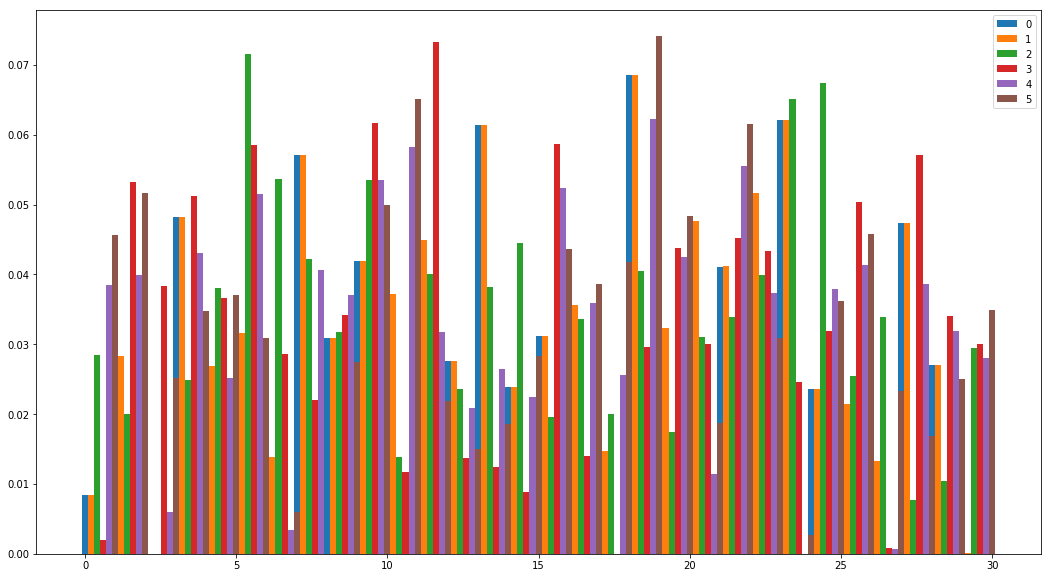

In [27]:
plt.figure(figsize=(18,10))

n_nodes, embed_dim = distributions.shape
ind = np.arange(embed_dim) 
width = 0.2
for i in range(n_nodes):
    plt.bar(ind+i*width, distributions[i], width, label=i)

# plt.ylabel('Scores')
# plt.title('Scores by group and gender')

# plt.xticks(ind + width / 2, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.legend(loc='best')
plt.show()

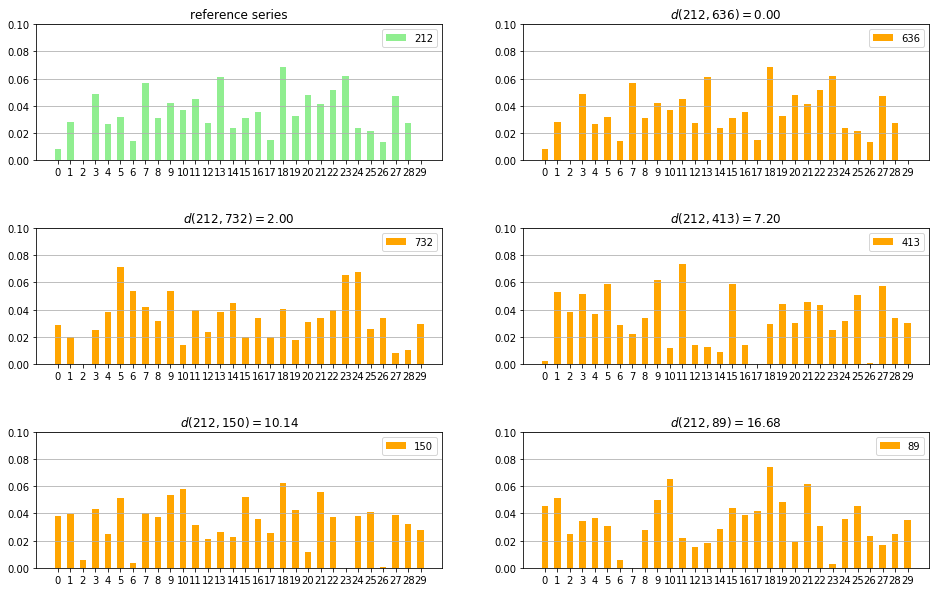

In [55]:
plt.figure(figsize=(16,10))


n_nodes, embed_dim = distributions.shape
ind = np.arange(embed_dim) 
width = 0.5
plt.subplot(321)
plt.bar(ind, distributions[0], width, label=select_nodes[0], color='lightgreen')
plt.ylim((0, 0.1))
plt.legend(loc='best')
plt.grid(axis='y')
plt.xticks(ind)
plt.title("reference series")

for i in range(1, n_nodes):
    plt.subplot(321 + i)
    plt.bar(ind, distributions[i], width, label=select_nodes[i], color='orange')
    plt.text
    plt.ylim((0, 0.1))
    plt.legend(loc='best')
    plt.grid(axis='y')
    plt.xticks(ind)
    plt.title("$d(212, {})={:.2f}$".format(select_nodes[i], dists[i]))

# plt.suptitle("KL embedding visualization", fontsize=16)

plt.subplots_adjust(hspace=0.5)
plt.show()

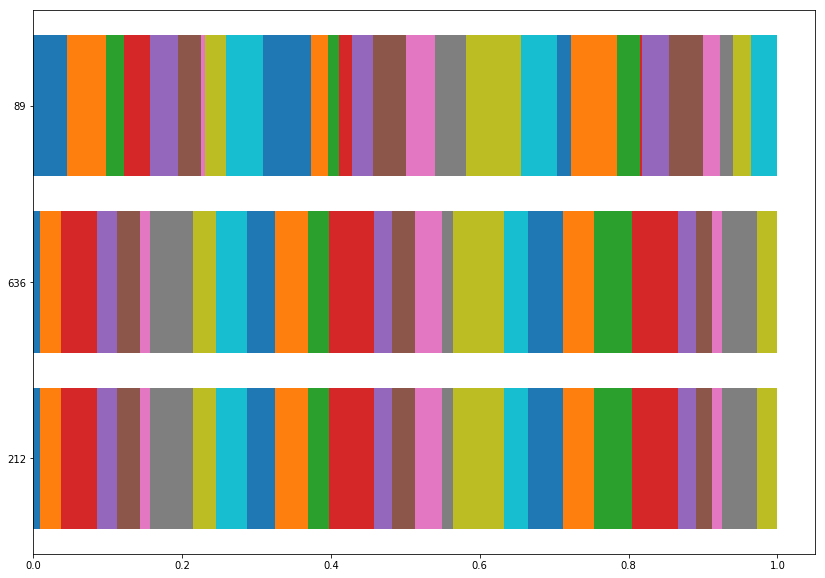

In [129]:
plt.figure(figsize=(14, 10))
plt.barh([str(e) for e in select_nodes], distributions[:, 0])
for i in range(1, 30):
    plt.barh([str(e) for e in select_nodes], distributions[:, i], left=distributions[:, :i].sum(1))